In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

import random
import os

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [25]:
# pip install optuna
# optuna.trial.Trial.suggest_categorical() : 리스트 범위 내에서 값을 선택한다.
# optuna.trial.Trial.suggest_int() : 범위 내에서 정수형 값을 선택한다.
# optuna.trial.Trial.suggest_float() : 범위 내에서 소수형 값을 선택한다.
# optuna.trial.Trial.suggest_uniform() : 범위 내에서 균일분포 값을 선택한다.
# optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
# optuna.trial.Trial.suggest_loguniform() : 범위 내에서 로그 함수 값을 선택한다.

In [26]:
path= '/opt/ml/level1_bookratingprediction_recsys-level1-recsys-06/data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


In [27]:
def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)


# 전처리

In [28]:
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
users = users.drop(['location'], axis=1)

In [29]:
ratings = pd.concat([train_ratings, test_ratings]).reset_index(drop=True)
context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
train_df = train_ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
test_df = test_ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')

In [30]:
loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

In [31]:
train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
train_df['location_country'] = train_df['location_country'].map(loc_country2idx)

test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

In [32]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [33]:
train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
train_df['age'] = train_df['age'].apply(age_map)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)

In [34]:
category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

In [35]:
train_df['category'] = train_df['category'].map(category2idx)
train_df['publisher'] = train_df['publisher'].map(publisher2idx)
train_df['language'] = train_df['language'].map(language2idx)
train_df['book_author'] = train_df['book_author'].map(author2idx)

test_df['category'] = test_df['category'].map(category2idx)
test_df['publisher'] = test_df['publisher'].map(publisher2idx)
test_df['language'] = test_df['language'].map(language2idx)
test_df['book_author'] = test_df['book_author'].map(author2idx)

In [36]:
train_df['id'] = train_df['user_id'].copy()
test_df['id'] = test_df['user_id'].copy()

train_df['bn'] = train_df['isbn'].copy()
test_df['bn'] = test_df['isbn'].copy()

In [37]:
for i in enumerate (list(train_df.columns)) :
    ca = i[1]
    train_df[ca] = train_df[ca].astype('str')
    test_df[ca] = test_df[ca].astype('str')
train_df['rating'] = train_df['rating'].astype('float64')
test_df['rating'] = test_df['rating'].astype('float64')

1. age는 범위가 좁기도 하고 str으로 해서 label encoding이 비효율적이라 판단 ! -> 실제로 범위도 작기 때문에 age는 수치형으로 판단하는게 분석적으로 봤을 때 더 모델 성능에 좋은 결과를 미칠 것 이라 판단
2. catb의 수치형 모델 알고리즘은 기존의 부스팅 모델들의 알고리즘과 같이 tree로 이루어짐 

In [38]:
cols_nums = {}
for col in train_df.columns:
    print(f'{col} 범주 수: {train_df[col].nunique()}')
    cols_nums[col] = train_df[col].nunique()

user_id 범주 수: 59803
isbn 범주 수: 129777
rating 범주 수: 10
age 범주 수: 6
location_city 범주 수: 11374
location_state 범주 수: 1487
location_country 범주 수: 318
category 범주 수: 3873
publisher 범주 수: 10408
language 범주 수: 25
book_author 범주 수: 54716
id 범주 수: 59803
bn 범주 수: 129777


In [39]:
type(list(train_df.drop(['rating','user_id','isbn'], axis =1).columns)[0])

str

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 306794
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           306795 non-null  object 
 1   isbn              306795 non-null  object 
 2   rating            306795 non-null  float64
 3   age               306795 non-null  object 
 4   location_city     306795 non-null  object 
 5   location_state    306795 non-null  object 
 6   location_country  306795 non-null  object 
 7   category          306795 non-null  object 
 8   publisher         306795 non-null  object 
 9   language          306795 non-null  object 
 10  book_author       306795 non-null  object 
 11  id                306795 non-null  object 
 12  bn                306795 non-null  object 
dtypes: float64(1), object(12)
memory usage: 32.8+ MB


# 모델링

## Optuna 함수 정의

In [41]:
def objective(trial):
  param = {
      
      "random_state":42,
      "objective" : "RMSE",
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }
  train_x, val_x, train_y, val_y = train_test_split(train_df.drop(['rating','user_id','isbn'], axis = 1), train_df['rating'], test_size=0.2)

  model = CatBoostRegressor(**param, task_type = 'GPU')
  model.fit(
      train_x,
      train_y,
      eval_set=[(val_x, val_y)],
      cat_features = list(train_df.drop(['rating','user_id','isbn'], axis =1).columns),
      verbose=100
  )

  cat_pred = model.predict(val_x)
  log_score = rmse(val_y, cat_pred)

  return log_score

In [42]:
# parameter 참고
# params_cat = {
#         "task_type" : "GPU",
#         "devices" : '0',
#         "random_state": SEED,
#         "learning_rate": 0.05,
#         "n_estimators": 2000,
#         "verbose" : 1,
#         "objective" : "RMSE",
#         "max_depth": 10,#trial.suggest_int("max_depth", 1, 16),
#         "colsample_bylevel": 1,#trial.suggest_float("colsample_bylevel", 0.8, 1.0),
#         #"subsample": 0.8, #trial.suggest_float("subsample", 0.3, 1.0), GPU 사용시 안될수도.
#         "min_child_samples": 50, #trial.suggest_int("min_child_samples", 5, 100),
#         "max_bin": 300, #trial.suggest_int("max_bin", 200, 500),
#         "cat_features" : list(train_df.drop(['age','rating','user_id','isbn'], axis =1).columns),
#         "one_hot_max_size" : 256
# }

## Optuna 활용한 모델 실행

In [43]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-30 08:25:25,642] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328108	test: 2.4321749	best: 2.4321749 (0)	total: 14.1ms	remaining: 1m 47s
100:	learn: 2.4273058	test: 2.4248424	best: 2.4248424 (100)	total: 1.24s	remaining: 1m 32s
200:	learn: 2.4273043	test: 2.4248248	best: 2.4248248 (200)	total: 2.44s	remaining: 1m 29s
bestTest = 2.424824667
bestIteration = 201
Shrink model to first 202 iterations.


[I 2022-10-30 08:25:31,901] Trial 0 finished with value: 2.4248248146321605 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4248248146321605.


0:	learn: 2.4346166	test: 2.4268810	best: 2.4268810 (0)	total: 12.7ms	remaining: 1m 48s
100:	learn: 2.4289878	test: 2.4211551	best: 2.4211551 (100)	total: 1.23s	remaining: 1m 41s
200:	learn: 2.4283507	test: 2.4206160	best: 2.4206160 (200)	total: 2.41s	remaining: 1m 39s
300:	learn: 2.4282779	test: 2.4205915	best: 2.4205898 (275)	total: 3.59s	remaining: 1m 37s
400:	learn: 2.4282698	test: 2.4206011	best: 2.4205898 (275)	total: 4.79s	remaining: 1m 36s
500:	learn: 2.4282692	test: 2.4206061	best: 2.4205898 (275)	total: 5.97s	remaining: 1m 35s
600:	learn: 2.4282691	test: 2.4206084	best: 2.4205898 (275)	total: 7.17s	remaining: 1m 34s
700:	learn: 2.4282694	test: 2.4206092	best: 2.4205898 (275)	total: 8.36s	remaining: 1m 32s
800:	learn: 2.4282693	test: 2.4206094	best: 2.4205898 (275)	total: 9.56s	remaining: 1m 31s
900:	learn: 2.4282692	test: 2.4206094	best: 2.4205898 (275)	total: 10.8s	remaining: 1m 31s
1000:	learn: 2.4282692	test: 2.4206094	best: 2.4205898 (275)	total: 12s	remaining: 1m 29s
110

[I 2022-10-30 08:27:20,805] Trial 1 finished with value: 2.420590147008885 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.420590147008885.


0:	learn: 2.4009979	test: 2.3903957	best: 2.3903957 (0)	total: 28.6ms	remaining: 1m 43s
100:	learn: 2.1907853	test: 2.1479792	best: 2.1479792 (100)	total: 2.77s	remaining: 1m 36s
200:	learn: 2.1685841	test: 2.1414757	best: 2.1414757 (200)	total: 5.3s	remaining: 1m 30s
300:	learn: 2.1513463	test: 2.1395526	best: 2.1394701 (298)	total: 7.84s	remaining: 1m 26s
400:	learn: 2.1373118	test: 2.1388683	best: 2.1387893 (395)	total: 10.4s	remaining: 1m 24s
500:	learn: 2.1240379	test: 2.1386040	best: 2.1385852 (461)	total: 13s	remaining: 1m 21s
600:	learn: 2.1110913	test: 2.1385420	best: 2.1382562 (585)	total: 15.6s	remaining: 1m 18s
700:	learn: 2.0991806	test: 2.1380013	best: 2.1379273 (689)	total: 18.2s	remaining: 1m 16s
800:	learn: 2.0871067	test: 2.1381510	best: 2.1376868 (747)	total: 20.8s	remaining: 1m 13s
900:	learn: 2.0759343	test: 2.1384379	best: 2.1376868 (747)	total: 23.5s	remaining: 1m 11s
1000:	learn: 2.0634734	test: 2.1392233	best: 2.1376868 (747)	total: 26.1s	remaining: 1m 8s
1100:

[I 2022-10-30 08:29:01,937] Trial 2 finished with value: 2.1376868814754526 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1376868814754526.


0:	learn: 2.3948099	test: 2.3895980	best: 2.3895980 (0)	total: 489ms	remaining: 12m 53s
100:	learn: 1.9559240	test: 2.1512670	best: 2.1509828 (90)	total: 46.1s	remaining: 11m 18s
200:	learn: 1.5165604	test: 2.1694362	best: 2.1509828 (90)	total: 1m 32s	remaining: 10m 36s
300:	learn: 1.1295556	test: 2.1947148	best: 2.1509828 (90)	total: 2m 18s	remaining: 9m 52s
400:	learn: 0.9021107	test: 2.2106452	best: 2.1509828 (90)	total: 3m 5s	remaining: 9m 7s
500:	learn: 0.7445873	test: 2.2211121	best: 2.1509828 (90)	total: 3m 51s	remaining: 8m 21s
600:	learn: 0.6185506	test: 2.2297713	best: 2.1509828 (90)	total: 4m 37s	remaining: 7m 34s
700:	learn: 0.5308423	test: 2.2351687	best: 2.1509828 (90)	total: 5m 23s	remaining: 6m 47s
800:	learn: 0.4620612	test: 2.2398877	best: 2.1509828 (90)	total: 6m 8s	remaining: 6m
900:	learn: 0.4044167	test: 2.2435580	best: 2.1509828 (90)	total: 6m 54s	remaining: 5m 14s
1000:	learn: 0.3576001	test: 2.2464646	best: 2.1509828 (90)	total: 7m 39s	remaining: 4m 28s
1100:	l

[I 2022-10-30 08:41:17,021] Trial 3 finished with value: 2.1509825667548097 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1376868814754526.


0:	learn: 2.4255668	test: 2.4360690	best: 2.4360690 (0)	total: 267ms	remaining: 5m 49s
100:	learn: 2.1913752	test: 2.2060536	best: 2.2060536 (100)	total: 24.8s	remaining: 4m 57s
200:	learn: 2.1252843	test: 2.1684655	best: 2.1684655 (200)	total: 49.7s	remaining: 4m 33s
300:	learn: 2.0885601	test: 2.1581396	best: 2.1581396 (300)	total: 1m 14s	remaining: 4m 9s
400:	learn: 2.0536595	test: 2.1539658	best: 2.1539648 (399)	total: 1m 39s	remaining: 3m 44s
500:	learn: 2.0210396	test: 2.1516483	best: 2.1516483 (500)	total: 2m 4s	remaining: 3m 20s
600:	learn: 1.9876049	test: 2.1499700	best: 2.1499700 (600)	total: 2m 29s	remaining: 2m 56s
700:	learn: 1.9606702	test: 2.1491516	best: 2.1491516 (700)	total: 2m 54s	remaining: 2m 31s
800:	learn: 1.9283208	test: 2.1485981	best: 2.1485822 (796)	total: 3m 19s	remaining: 2m 6s
900:	learn: 1.8769261	test: 2.1480156	best: 2.1480156 (900)	total: 3m 44s	remaining: 1m 41s
1000:	learn: 1.8083530	test: 2.1488449	best: 2.1480156 (900)	total: 4m 9s	remaining: 1m 16

[I 2022-10-30 08:46:53,257] Trial 4 finished with value: 2.1480157000143723 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1376868814754526.


0:	learn: 2.4015188	test: 2.4101231	best: 2.4101231 (0)	total: 271ms	remaining: 42m 41s
bestTest = 2.269183034
bestIteration = 39
Shrink model to first 40 iterations.


[I 2022-10-30 08:47:11,551] Trial 5 finished with value: 2.2691830769339942 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1376868814754526.


0:	learn: 2.4193781	test: 2.4139423	best: 2.4139423 (0)	total: 28.2ms	remaining: 3m 58s
100:	learn: 2.2043603	test: 2.1576007	best: 2.1576007 (100)	total: 2.65s	remaining: 3m 39s
200:	learn: 2.1914344	test: 2.1482359	best: 2.1482359 (200)	total: 5.37s	remaining: 3m 40s
300:	learn: 2.1838684	test: 2.1445032	best: 2.1445032 (300)	total: 8.06s	remaining: 3m 38s
400:	learn: 2.1730260	test: 2.1408912	best: 2.1408912 (400)	total: 10.5s	remaining: 3m 30s
500:	learn: 2.1636607	test: 2.1388305	best: 2.1388305 (500)	total: 12.8s	remaining: 3m 23s
600:	learn: 2.1560157	test: 2.1376244	best: 2.1376244 (600)	total: 15.2s	remaining: 3m 18s
700:	learn: 2.1487540	test: 2.1368981	best: 2.1368718 (699)	total: 17.5s	remaining: 3m 14s
800:	learn: 2.1421367	test: 2.1361607	best: 2.1361607 (800)	total: 20s	remaining: 3m 11s
bestTest = 2.135896738
bestIteration = 858
Shrink model to first 859 iterations.


[I 2022-10-30 08:47:38,262] Trial 6 finished with value: 2.1358967193313947 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1358967193313947.


0:	learn: 2.3670903	test: 2.3591841	best: 2.3591841 (0)	total: 166ms	remaining: 2m 53s
100:	learn: 1.8830949	test: 2.1697921	best: 2.1576489 (62)	total: 14.5s	remaining: 2m 15s
200:	learn: 1.4579714	test: 2.2118478	best: 2.1576489 (62)	total: 28.5s	remaining: 2m
300:	learn: 1.1886992	test: 2.2438778	best: 2.1576489 (62)	total: 42.6s	remaining: 1m 45s
400:	learn: 0.9957266	test: 2.2658816	best: 2.1576489 (62)	total: 56.7s	remaining: 1m 31s
500:	learn: 0.8309848	test: 2.2828274	best: 2.1576489 (62)	total: 1m 10s	remaining: 1m 17s
600:	learn: 0.7137950	test: 2.2932183	best: 2.1576489 (62)	total: 1m 24s	remaining: 1m 3s
700:	learn: 0.6228970	test: 2.3004026	best: 2.1576489 (62)	total: 1m 38s	remaining: 48.9s
800:	learn: 0.5489670	test: 2.3070661	best: 2.1576489 (62)	total: 1m 52s	remaining: 34.9s
900:	learn: 0.4806895	test: 2.3130563	best: 2.1576489 (62)	total: 2m 6s	remaining: 20.8s
1000:	learn: 0.4244136	test: 2.3178728	best: 2.1576489 (62)	total: 2m 20s	remaining: 6.73s
1048:	learn: 0.4

[I 2022-10-30 08:50:09,892] Trial 7 finished with value: 2.157648995432325 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1358967193313947.


0:	learn: 2.3646642	test: 2.3609053	best: 2.3609053 (0)	total: 13.2ms	remaining: 52.3s
100:	learn: 2.2028145	test: 2.1698509	best: 2.1698333 (98)	total: 1.4s	remaining: 53.5s
200:	learn: 2.1980219	test: 2.1674125	best: 2.1674125 (200)	total: 2.74s	remaining: 51.5s
300:	learn: 2.1942434	test: 2.1657156	best: 2.1657156 (300)	total: 4.06s	remaining: 49.6s
400:	learn: 2.1912122	test: 2.1649866	best: 2.1649814 (399)	total: 5.35s	remaining: 47.7s
500:	learn: 2.1884024	test: 2.1637323	best: 2.1637017 (498)	total: 6.64s	remaining: 46.1s
600:	learn: 2.1861419	test: 2.1632970	best: 2.1632970 (600)	total: 7.96s	remaining: 44.7s
700:	learn: 2.1838278	test: 2.1627135	best: 2.1626717 (698)	total: 9.23s	remaining: 43.2s
800:	learn: 2.1819524	test: 2.1625281	best: 2.1624631 (767)	total: 10.5s	remaining: 41.8s
900:	learn: 2.1799792	test: 2.1623392	best: 2.1623165 (889)	total: 11.9s	remaining: 40.5s
1000:	learn: 2.1782506	test: 2.1619892	best: 2.1619661 (997)	total: 13.2s	remaining: 39.2s
1100:	learn: 2

[I 2022-10-30 08:51:06,841] Trial 8 finished with value: 2.1604344534535995 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1358967193313947.


0:	learn: 2.4302525	test: 2.4338086	best: 2.4338086 (0)	total: 39.5ms	remaining: 5m 9s
100:	learn: 2.2772791	test: 2.2768112	best: 2.2768112 (100)	total: 3.88s	remaining: 4m 57s
200:	learn: 2.2316193	test: 2.2380484	best: 2.2380484 (200)	total: 7.65s	remaining: 4m 51s
300:	learn: 2.2071521	test: 2.2236782	best: 2.2236782 (300)	total: 11.5s	remaining: 4m 48s
400:	learn: 2.1889603	test: 2.2159588	best: 2.2159588 (400)	total: 15.4s	remaining: 4m 45s
500:	learn: 2.1740406	test: 2.2109997	best: 2.2109997 (500)	total: 19.2s	remaining: 4m 41s
600:	learn: 2.1600413	test: 2.2065863	best: 2.2065863 (600)	total: 23s	remaining: 4m 37s
700:	learn: 2.1471395	test: 2.2034797	best: 2.2034797 (700)	total: 26.9s	remaining: 4m 33s
800:	learn: 2.1357070	test: 2.2009816	best: 2.2009816 (800)	total: 30.7s	remaining: 4m 30s
900:	learn: 2.1246257	test: 2.1989574	best: 2.1989574 (900)	total: 34.6s	remaining: 4m 26s
1000:	learn: 2.1142657	test: 2.1975319	best: 2.1975319 (1000)	total: 38.4s	remaining: 4m 22s
110

[I 2022-10-30 08:52:05,312] Trial 9 finished with value: 2.193661601478618 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1358967193313947.


Best Score: 2.1358967193313947
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


## 학습한 best Parameter 활용하여 CatB에 적용

### 계층별 교차 검증 활용

In [44]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train_df.drop(['user_id','isbn'], axis = 1), train_df['rating']):
  folds.append((train_idx,valid_idx))

In [45]:
random.seed(42)
cat_models={}

cat_features = list(range(10))

for fold in range(5):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = train_df.drop(['user_id','isbn','rating'], axis = 1).iloc[train_idx].values 
  X_valid = train_df.drop(['user_id','isbn','rating'], axis = 1).iloc[valid_idx].values
  y_train = train_df['rating'][train_idx].values
  y_valid = train_df['rating'][valid_idx].values

  cat = CatBoostRegressor(**study.best_params, task_type = 'GPU')
  cat.fit(X_train, y_train,
          eval_set=[(X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  pred = cat.predict(test_df.drop(['user_id', 'isbn', 'rating'],axis = 1))
  cat_models[fold] = pred
  print(f'================================================================================\n\n')

====================================1============================================
0:	learn: 2.4210651	test: 2.4187388	best: 2.4187388 (0)	total: 29.2ms	remaining: 4m 7s
100:	learn: 2.2058807	test: 2.1583849	best: 2.1583849 (100)	total: 2.67s	remaining: 3m 40s
200:	learn: 2.1924549	test: 2.1475737	best: 2.1475737 (200)	total: 5.35s	remaining: 3m 39s
300:	learn: 2.1845426	test: 2.1434064	best: 2.1434064 (300)	total: 8.05s	remaining: 3m 38s
400:	learn: 2.1737918	test: 2.1395146	best: 2.1395146 (400)	total: 10.4s	remaining: 3m 29s
500:	learn: 2.1642069	test: 2.1373555	best: 2.1373555 (500)	total: 12.7s	remaining: 3m 21s
600:	learn: 2.1563353	test: 2.1359140	best: 2.1359140 (600)	total: 15s	remaining: 3m 15s
700:	learn: 2.1497293	test: 2.1352651	best: 2.1352651 (700)	total: 17.3s	remaining: 3m 11s
800:	learn: 2.1429562	test: 2.1345751	best: 2.1345727 (792)	total: 19.6s	remaining: 3m 6s
900:	learn: 2.1364769	test: 2.1338112	best: 2.1338112 (900)	total: 21.9s	remaining: 3m 3s
bestTest = 2.133

# 변수 중요도 시각화

In [46]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()
    

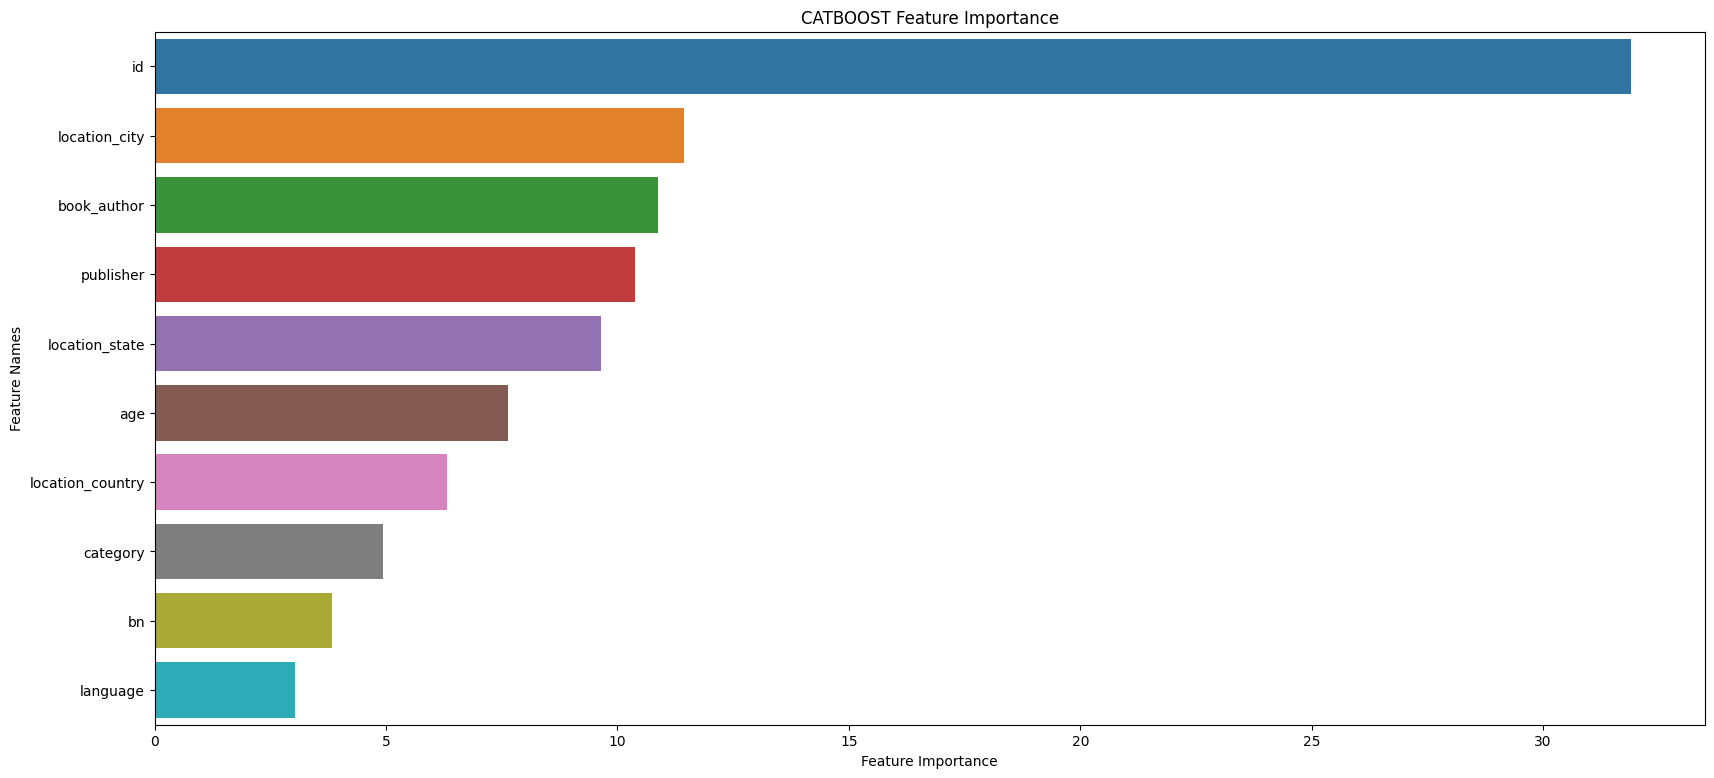

In [47]:
plot_feature_importance(cat.get_feature_importance(), test_df.drop(['user_id', 'isbn', 'rating'],axis = 1).columns, 'CATBOOST')

In [48]:
cat.get_feature_importance()

array([ 7.64396163, 11.43860089,  9.64126124,  6.30665511,  4.94374266,
       10.38758106,  3.03385682, 10.88481622, 31.89690796,  3.82261641])

In [49]:
train_df.drop(['user_id', 'isbn'], axis = 1).columns

Index(['rating', 'age', 'location_city', 'location_state', 'location_country',
       'category', 'publisher', 'language', 'book_author', 'id', 'bn'],
      dtype='object')

In [50]:
pip install sns

Note: you may need to restart the kernel to use updated packages.


In [51]:
submit['rating'] = 0

In [52]:
for fold in range(5):
    submit['rating'] += cat_models[fold] / 5

In [53]:
import datetime
now = datetime.datetime.now()
created_time = now.strftime('%m%d-%H%M')

submit.to_csv(f'../data/{created_time}_submit.csv',index=False)

In [54]:
submit

,user_id,isbn,rating
0,11676,0002005018,7.086857
1,116866,0002005018,7.256944
2,152827,0060973129,7.530020
3,157969,0374157065,7.565263
4,67958,0399135782,7.333589
...,...,...,...
76694,278543,1576734218,6.195006
76695,278563,3492223710,6.223573
76696,278633,1896095186,6.332805
76697,278668,8408044079,5.315886
